In [21]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mimiciii/mimic-iii-clinical-database-demo-1.4/OUTPUTEVENTS.csv
/kaggle/input/mimiciii/mimic-iii-clinical-database-demo-1.4/D_LABITEMS.csv
/kaggle/input/mimiciii/mimic-iii-clinical-database-demo-1.4/DRGCODES.csv
/kaggle/input/mimiciii/mimic-iii-clinical-database-demo-1.4/SHA256SUMS.txt
/kaggle/input/mimiciii/mimic-iii-clinical-database-demo-1.4/D_ICD_DIAGNOSES.csv
/kaggle/input/mimiciii/mimic-iii-clinical-database-demo-1.4/DATETIMEEVENTS.csv
/kaggle/input/mimiciii/mimic-iii-clinical-database-demo-1.4/CAREGIVERS.csv
/kaggle/input/mimiciii/mimic-iii-clinical-database-demo-1.4/INPUTEVENTS_MV.csv
/kaggle/input/mimiciii/mimic-iii-clinical-database-demo-1.4/CHARTEVENTS.csv
/kaggle/input/mimiciii/mimic-iii-clinical-database-demo-1.4/PRESCRIPTIONS.csv
/kaggle/input/mimiciii/mimic-iii-clinical-database-demo-1.4/D_ICD_PROCEDURES.csv
/kaggle/input/mimiciii/mimic-iii-clinical-database-demo-1.4/PATIENTS.csv
/kaggle/input/mimiciii/mimic-iii-clinical-database-demo-1.4/TRANSFERS.csv
/kagg

In [22]:
# ====================================================
# 1. Libraries & Setup
# ====================================================
import os
import random
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
from typing import List, Tuple, Dict

import gym
from gym import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback

import warnings
warnings.filterwarnings("ignore")

# Seed for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully



LOADING + PREPROCESSING MIMIC-III
⚠️ Could not use D_LABITEMS label selection; falling back to most frequent itemid.
✓ Selected lab fallback: ITEMID_51221 (ITEMID=51221)
✓ Loaded 1800 observations for ITEMID_51221
✓ Unique patients: 100
✓ % of observations in NORMAL_RANGE (70.0, 140.0): 0.00%


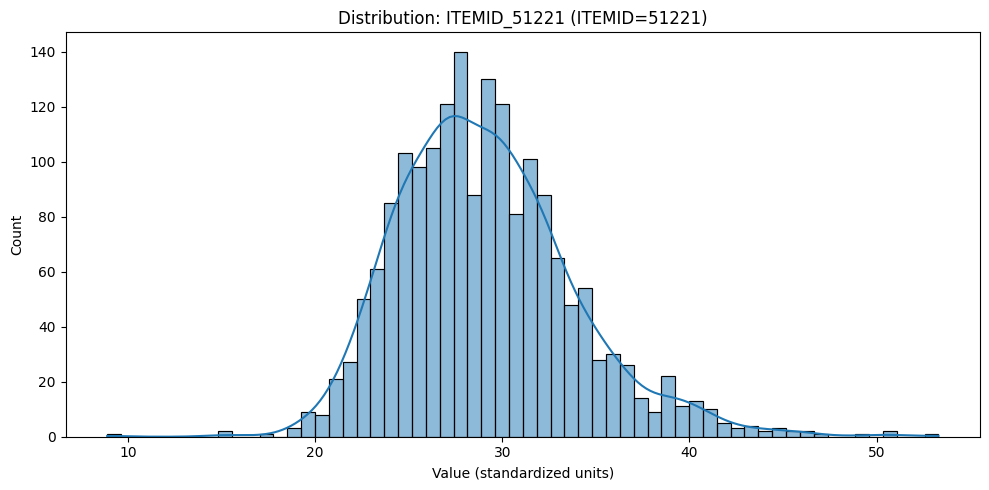

In [23]:
# ====================================================
# 2. Load and Preprocess MIMIC-III Dataset
# ====================================================
DATA_PATH = "/kaggle/input/mimiciii/mimic-iii-clinical-database-demo-1.4"

print("\n" + "="*50)
print("LOADING + PREPROCESSING MIMIC-III")
print("="*50)

# --- Load tables
labevents = pd.read_csv(f"{DATA_PATH}/LABEVENTS.csv", low_memory=False)
labevents = labevents[['subject_id', 'hadm_id', 'itemid', 'charttime', 'valuenum', 'valueuom']].copy()
labevents = labevents.dropna(subset=['valuenum'])
labevents['charttime'] = pd.to_datetime(labevents['charttime'], errors='coerce')
labevents = labevents.dropna(subset=['charttime'])

# --- Try to load D_LABITEMS to choose a single coherent lab (recommended)
try:
    d_labitems = pd.read_csv(f"{DATA_PATH}/D_LABITEMS.csv", low_memory=False)
    d_labitems['LABEL'] = d_labitems['LABEL'].astype(str)

    TARGET_LAB_LABEL = "GLUCOSE"  # change if you want a different lab
    candidate = d_labitems[d_labitems['LABEL'].str.contains(TARGET_LAB_LABEL, case=False, na=False)].copy()

    if len(candidate) == 0:
        raise ValueError(f"No labitems matched label contains '{TARGET_LAB_LABEL}'")

    candidate_itemids = candidate['ITEMID'].astype(int).unique().tolist()

    # pick the most frequent matching itemid in LABEVENTS
    counts = labevents[labevents['itemid'].isin(candidate_itemids)]['itemid'].value_counts()
    LAB_ITEMID = int(counts.index[0])

    LAB_LABEL = candidate.loc[candidate['ITEMID'].astype(int) == LAB_ITEMID, 'LABEL'].iloc[0]
    print(f"✓ Selected lab: {LAB_LABEL} (ITEMID={LAB_ITEMID})")

except Exception as e:
    print("⚠️ Could not use D_LABITEMS label selection; falling back to most frequent itemid.")
    LAB_ITEMID = int(labevents['itemid'].value_counts().index[0])
    LAB_LABEL = f"ITEMID_{LAB_ITEMID}"
    print(f"✓ Selected lab fallback: {LAB_LABEL} (ITEMID={LAB_ITEMID})")

# --- Filter to ONE lab item
lab = labevents[labevents['itemid'] == LAB_ITEMID].copy()

# --- Unit handling (basic)
# Keep mg/dL as-is; convert mmol/L -> mg/dL for glucose if it appears
lab['valueuom'] = lab['valueuom'].astype(str)
is_mmol = lab['valueuom'].str.contains("mmol", case=False, na=False)
# For glucose: 1 mmol/L ≈ 18 mg/dL
lab.loc[is_mmol, 'valuenum'] = lab.loc[is_mmol, 'valuenum'] * 18.0
lab.loc[is_mmol, 'valueuom'] = "mg/dL"

# --- Build patient time series
patient_states = (
    lab.groupby(['subject_id', 'hadm_id', 'charttime'])['valuenum']
       .mean()
       .reset_index()
       .sort_values(['subject_id', 'hadm_id', 'charttime'])
       .reset_index(drop=True)
)

print(f"✓ Loaded {len(patient_states)} observations for {LAB_LABEL}")
print(f"✓ Unique patients: {patient_states['subject_id'].nunique()}")

# --- Define clinical ranges (defaults for glucose mg/dL)
# If you are not using glucose, adjust these.
NORMAL_RANGE = (70.0, 140.0)
CRITICAL_LOW = 50.0
CRITICAL_HIGH = 250.0

vals = patient_states['valuenum'].values.astype(np.float32)
in_range_pct = ((vals >= NORMAL_RANGE[0]) & (vals <= NORMAL_RANGE[1])).mean() * 100.0
print(f"✓ % of observations in NORMAL_RANGE {NORMAL_RANGE}: {in_range_pct:.2f}%")

# --- Quick sanity plots (optional)
plt.figure(figsize=(10, 5))
sns.histplot(vals, bins=60, kde=True)
plt.title(f"Distribution: {LAB_LABEL} (ITEMID={LAB_ITEMID})")
plt.xlabel("Value (standardized units)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


EXPLORATORY DATA ANALYSIS

📊 Patient States Summary Statistics:
         subject_id        hadm_id                      charttime     valuenum
count   1800.000000    1800.000000                           1800  1800.000000
mean   26646.388889  156942.193889  2152-06-14 11:04:08.466665472    29.099778
min    10006.000000  100375.000000            2102-08-29 18:45:00     8.900000
25%    10094.000000  134993.000000            2126-08-26 04:45:00    25.800000
50%    40204.000000  160445.000000            2145-12-15 18:49:00    28.700000
75%    42075.000000  178739.250000  2175-10-03 09:17:44.999999488    31.800000
max    44228.000000  199395.000000            2202-10-11 04:45:00    53.300000
std    15980.257300   27246.152066                            NaN     4.741198

🔍 Missing Values:
subject_id    0
hadm_id       0
charttime     0
valuenum      0
dtype: int64


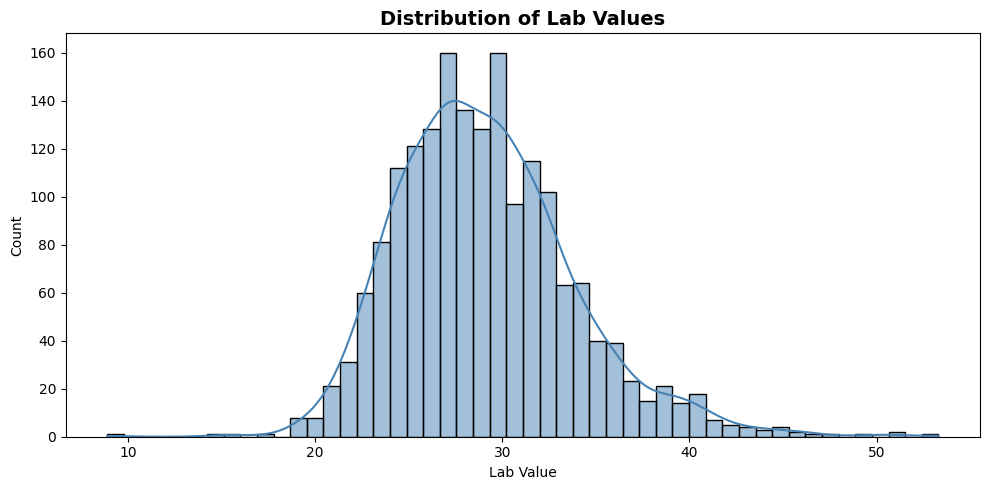

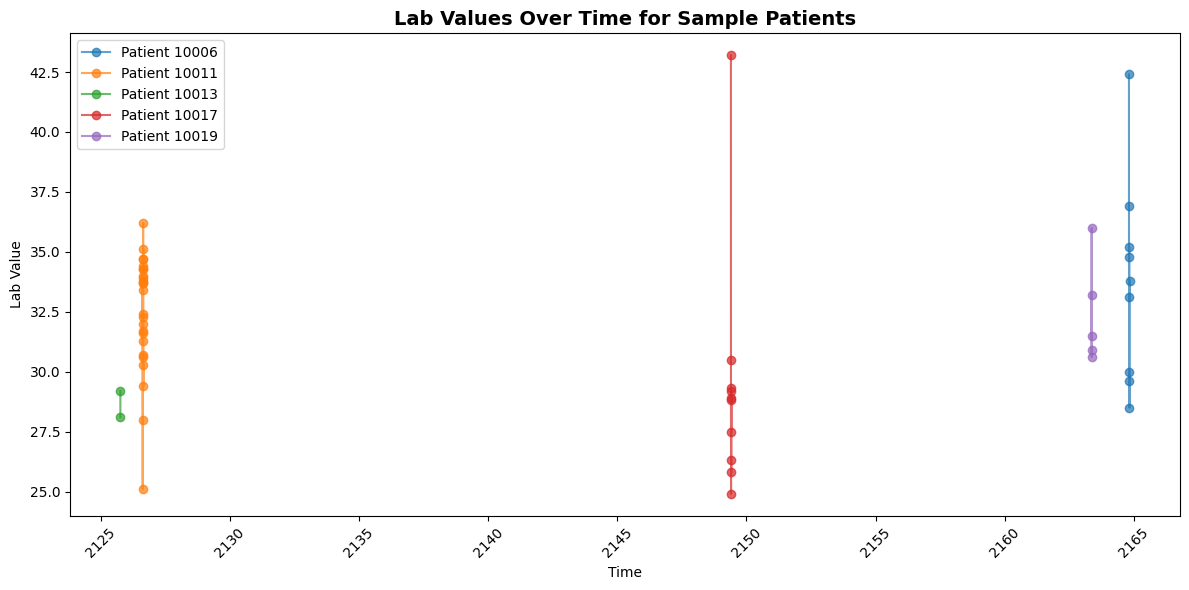

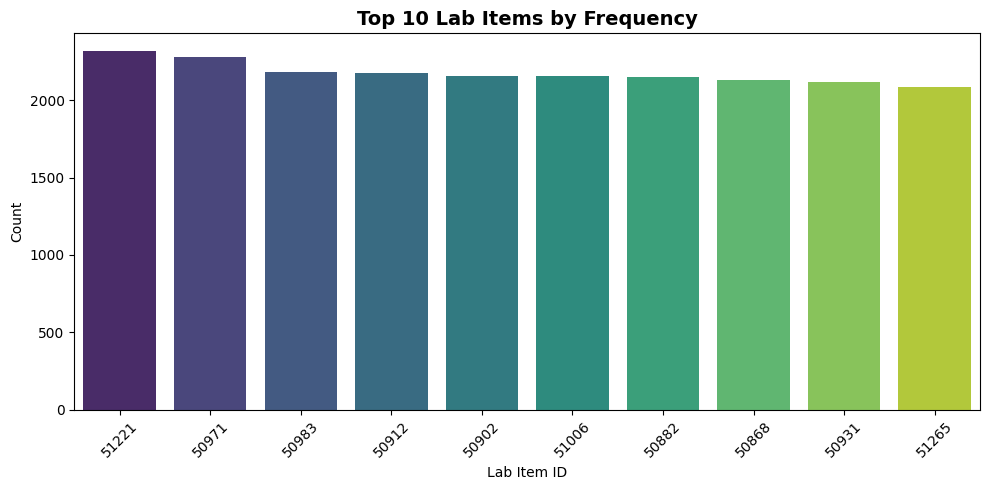

In [24]:
# ====================================================
# 3. Exploratory Data Analysis
# ====================================================
print("\n" + "="*50)
print("EXPLORATORY DATA ANALYSIS")
print("="*50)

# Summary statistics
print("\n📊 Patient States Summary Statistics:")
print(patient_states.describe())

# Check missing values
print("\n🔍 Missing Values:")
print(patient_states.isnull().sum())

# Distribution of lab values
plt.figure(figsize=(10,5))
sns.histplot(patient_states['valuenum'], bins=50, kde=True, color='steelblue')
plt.title("Distribution of Lab Values", fontsize=14, fontweight='bold')
plt.xlabel("Lab Value")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Time series for sample patients
sample_patients = patient_states['subject_id'].unique()[:5]
plt.figure(figsize=(12,6))
for pid in sample_patients:
    temp = patient_states[patient_states['subject_id']==pid]
    plt.plot(temp['charttime'], temp['valuenum'], marker='o', label=f"Patient {pid}", alpha=0.7)
    
plt.xlabel("Time")
plt.ylabel("Lab Value")
plt.title("Lab Values Over Time for Sample Patients", fontsize=14, fontweight='bold')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Top lab items frequency
top_lab_counts = labevents_filtered['itemid'].value_counts().head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_lab_counts.index.astype(str), y=top_lab_counts.values, palette='viridis')
plt.xticks(rotation=45)
plt.xlabel("Lab Item ID")
plt.ylabel("Count")
plt.title("Top 10 Lab Items by Frequency", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [25]:
# ====================================================
# 4. Build Episodes
# ====================================================
print("\n" + "="*50)
print("EPISODE CONSTRUCTION")
print("="*50)

grouped = patient_states.groupby(['subject_id','hadm_id'])
episodes = []
for (_, _), g in grouped:
    vals = g['valuenum'].values.astype(np.float32)
    if len(vals) >= 2:
        episodes.append(vals)

# Train / Val / Test split
n = len(episodes)
idx = np.arange(n)
np.random.shuffle(idx)
train_end = int(0.7 * n)
val_end = int(0.85 * n)

train_eps = [episodes[i] for i in idx[:train_end]]
val_eps   = [episodes[i] for i in idx[train_end:val_end]]
test_eps  = [episodes[i] for i in idx[val_end:]]

print(f"✓ Total episodes: {n}")
print(f"✓ Train episodes: {len(train_eps)}")
print(f"✓ Validation episodes: {len(val_eps)}")
print(f"✓ Test episodes: {len(test_eps)}")


EPISODE CONSTRUCTION
✓ Total episodes: 126
✓ Train episodes: 88
✓ Validation episodes: 19
✓ Test episodes: 19


In [26]:
# ====================================================
# 5. Clinical Guidelines Simulator (Rule-Based Feedback)
# ====================================================
class ClinicalGuidelinesSimulator:
    """
    Rule-based 'expert' used to generate preferences between trajectories.

    Design goals:
    - prefer trajectories that stay in range
    - strongly avoid critical extremes
    - prefer intervening when out-of-range, but penalize unnecessary interventions
    """
    def __init__(
        self,
        normal_range=(70.0, 140.0),
        critical_low=50.0,
        critical_high=250.0,
        hysteresis=10.0,
        intervention_cost=0.15,
    ):
        self.normal_range = normal_range
        self.critical_low = critical_low
        self.critical_high = critical_high
        self.hysteresis = float(hysteresis)
        self.intervention_cost = float(intervention_cost)

        self.center = 0.5 * (self.normal_range[0] + self.normal_range[1])
        self.half_width = max(1e-6, 0.5 * (self.normal_range[1] - self.normal_range[0]))

    def get_expert_action(self, state: float) -> int:
        """
        A simple policy with hysteresis:
        - intervene if sufficiently below/above normal band
        - don't intervene if inside the band (or very close)
        """
        low, high = self.normal_range
        if state < (low - self.hysteresis) or state > (high + self.hysteresis):
            return 1
        return 0

    def score_trajectory(self, traj: List[Tuple[float, int, float]]) -> float:
        """
        traj is list of (state, action, next_state)
        """
        if len(traj) == 0:
            return -1e9

        score = 0.0
        for (s, a, ns) in traj:
            # Critical safety penalty (dominant)
            if ns < self.critical_low or ns > self.critical_high:
                score -= 8.0

            # Dense closeness reward (normalized distance)
            dist = abs(ns - self.center) / self.half_width
            score += 1.5 * (1.0 - min(dist, 3.0))  # bounded contribution

            # In-range bonus
            if self.normal_range[0] <= ns <= self.normal_range[1]:
                score += 1.0

            # Encourage "appropriate" intervention decisions
            expert_a = self.get_expert_action(s)
            score += 0.4 if a == expert_a else -0.4

            # Penalize unnecessary interventions when already in-range
            if a == 1 and (self.normal_range[0] <= s <= self.normal_range[1]):
                score -= 0.8

            # Mild general intervention cost
            score -= self.intervention_cost * float(a)

        return score

    def compare_trajectories(self, traj1, traj2) -> int:
        """
        Returns 1 if traj2 is preferred over traj1, else 0.
        """
        s1 = self.score_trajectory(traj1)
        s2 = self.score_trajectory(traj2)
        return 1 if s2 > s1 else 0

In [31]:
# ====================================================
# 6. Preference Reward Model (Learned from Comparisons)
# ====================================================
import torch
import torch.nn as nn
import torch.nn.functional as F

class PreferenceRewardModel:
    """
    Neural reward model trained from pairwise trajectory preferences (Bradley–Terry).

    - transition reward r(s,a,s') is predicted by an MLP
    - trajectory return is sum of transition rewards
    - preference probability P(traj2 preferred) = sigmoid(R2 - R1)
    """
    def __init__(self, obs_scale: float = 1.0, device: str = None, lr: float = 3e-4, seed: int = 42):
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.obs_scale = float(obs_scale)

        torch.manual_seed(seed)

        # Input features: [s_norm, s_next_norm, delta_norm, action]
        self.net = nn.Sequential(
            nn.Linear(4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Tanh(),  # bound rewards for PPO stability
        ).to(self.device)

        self.opt = torch.optim.Adam(self.net.parameters(), lr=lr)
        self.prefs = []  # list of (traj1, traj2, pref_label) pref_label=1 if traj2 preferred
        self.last_loss = None

    def _featurize(self, s: float, a: int, ns: float) -> torch.Tensor:
        s_n = float(s) / self.obs_scale
        ns_n = float(ns) / self.obs_scale
        d_n = (ns_n - s_n)
        x = torch.tensor([s_n, ns_n, d_n, float(a)], dtype=torch.float32, device=self.device)
        return x

    @torch.no_grad()
    def get_reward(self, state: float, action: int, next_state: float) -> float:
        self.net.eval()
        x = self._featurize(state, action, next_state).unsqueeze(0)  # [1,4]
        r = self.net(x).squeeze().item()
        return float(r)

    def add_preference(self, traj1, traj2, pref_label: int):
        # pref_label=1 means traj2 is preferred over traj1
        self.prefs.append((traj1, traj2, int(pref_label)))

    def _traj_return(self, traj) -> torch.Tensor:
        if len(traj) == 0:
            return torch.tensor(0.0, device=self.device)

        xs = [self._featurize(s, a, ns) for (s, a, ns) in traj]
        X = torch.stack(xs, dim=0)  # [T, 4]
        R = self.net(X).sum()       # scalar
        return R

    def update(self, batch_size: int = 32, epochs: int = 3, drop_last: bool = False):
        """
        Robust Bradley–Terry update that cannot crash on batch_size=1.

        Key fix:
        - Avoid squeeze() collapsing batch dimension.
        - Force logits and targets to 1D [B] via view(-1).
        """
        if len(self.prefs) < max(50, batch_size):
            return

        self.net.train()
        idx = torch.randperm(len(self.prefs))

        losses = []

        for _ in range(int(epochs)):
            for start in range(0, len(idx), int(batch_size)):
                b = idx[start:start + int(batch_size)]
                if drop_last and len(b) < batch_size:
                    continue
                if len(b) == 0:
                    continue

                batch = [self.prefs[i] for i in b.tolist()]

                logits_list = []
                ys_list = []

                for (t1, t2, y) in batch:
                    R1 = self._traj_return(t1)  # scalar
                    R2 = self._traj_return(t2)  # scalar
                    logits_list.append(R2 - R1)                 # scalar tensor
                    ys_list.append(torch.tensor(float(y), device=self.device))  # scalar tensor

                # Stack => [B], never becomes scalar even when B=1
                logits = torch.stack(logits_list, dim=0).view(-1)  # [B]
                ys = torch.stack(ys_list, dim=0).view(-1)          # [B]

                loss = F.binary_cross_entropy_with_logits(logits, ys)

                self.opt.zero_grad(set_to_none=True)
                loss.backward()
                nn.utils.clip_grad_norm_(self.net.parameters(), 1.0)
                self.opt.step()

                losses.append(loss.item())

        self.last_loss = float(sum(losses) / max(1, len(losses)))
        self.net.eval()

In [28]:
# ====================================================
# 7. HITL Environment with Preference Learning
# ====================================================
class HITLClinicalEnv(gym.Env):
    """
    Key fix vs your previous env:
    - environment maintains a true evolving state (self.current_val)
    - actions affect future state and therefore future reward
    - real patient episode is used ONLY to provide patient-specific drift (baseline_delta)
    """
    def __init__(
        self,
        episodes_list,
        reward_model: PreferenceRewardModel = None,
        normal_range=(70.0, 140.0),
        critical_low=50.0,
        critical_high=250.0,
        alpha=0.20,                 # intervention strength
        noise_no_intervene=6.0,
        noise_intervene=3.5,
        pref_weight=0.0,            # gradually increased by callback
        lagrange_lambda=0.0,        # updated by callback
        base_intervention_cost=0.05,
        seed: int = 42,
    ):
        super().__init__()
        self.episodes_list = episodes_list
        self.reward_model = reward_model

        self.normal_range = normal_range
        self.critical_low = critical_low
        self.critical_high = critical_high

        self.alpha = float(alpha)
        self.noise_no_intervene = float(noise_no_intervene)
        self.noise_intervene = float(noise_intervene)

        self.pref_weight = float(pref_weight)
        self.lagrange_lambda = float(lagrange_lambda)
        self.base_intervention_cost = float(base_intervention_cost)

        self.center = 0.5 * (self.normal_range[0] + self.normal_range[1])
        self.half_width = max(1e-6, 0.5 * (self.normal_range[1] - self.normal_range[0]))

        self.rng = np.random.RandomState(seed)

        # Observation: [current_norm, deviation_norm, delta_norm, last_action]
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(4,), dtype=np.float32)
        self.action_space = spaces.Discrete(2)

        # Episode trackers
        self.current_episode = None
        self.t = 0
        self.current_val = None
        self.prev_val = None
        self.last_action = 0
        self.trajectory_buffer = []

    def set_lagrange_lambda(self, lam: float):
        self.lagrange_lambda = float(lam)

    def set_pref_weight(self, w: float):
        self.pref_weight = float(w)

    def _obs(self) -> np.ndarray:
        cur_n = (self.current_val - self.center) / self.half_width
        dev_n = abs(self.current_val - self.center) / self.half_width
        delta_n = (self.current_val - self.prev_val) / self.half_width if self.prev_val is not None else 0.0
        return np.array([cur_n, dev_n, delta_n, float(self.last_action)], dtype=np.float32)

    def reset(self):
        self.current_episode = random.choice(self.episodes_list)
        self.t = 0
        self.trajectory_buffer = []

        self.current_val = float(self.current_episode[0])
        self.prev_val = self.current_val
        self.last_action = 0

        return self._obs()

    def step(self, action):
        action = int(action)
        state = float(self.current_val)

        # Patient-specific drift from data (baseline delta)
        done = False
        if self.t >= (len(self.current_episode) - 2):
            done = True

        baseline_delta = float(self.current_episode[self.t + 1] - self.current_episode[self.t])

        # Intervention effect: push toward center
        if action == 1:
            effect = self.alpha * (self.center - state)
            noise = self.rng.normal(scale=self.noise_intervene)
        else:
            effect = 0.0
            noise = self.rng.normal(scale=self.noise_no_intervene)

        next_val = state + baseline_delta + effect + noise

        # Hard safety clipping to avoid runaway numerical instability
        next_val = float(np.clip(next_val, self.critical_low - 30.0, self.critical_high + 30.0))

        # --- Reward on NEXT state (credit assignment)
        # Dense shaping:
        dist_now = abs(state - self.center) / self.half_width
        dist_next = abs(next_val - self.center) / self.half_width

        improve = (dist_now - dist_next)  # positive if moved toward center
        in_range = float(self.normal_range[0] <= next_val <= self.normal_range[1])

        # Safety penalty dominates
        critical = float(next_val < self.critical_low or next_val > self.critical_high)

        env_reward = (
            1.0 * in_range +
            0.35 * improve -
            2.5 * critical -
            self.base_intervention_cost * float(action)
        )

        # Preference reward (learned)
        pref_r = 0.0
        if self.reward_model is not None:
            pref_r = self.reward_model.get_reward(state, action, next_val)

        # Lagrangian penalty encourages meeting a target intervention rate
        lagr_pen = self.lagrange_lambda * float(action)

        reward = float(env_reward + self.pref_weight * pref_r - lagr_pen)

        # Track trajectory for preferences
        self.trajectory_buffer.append((state, action, next_val))

        # Update internal state
        self.t += 1
        self.prev_val = state
        self.current_val = next_val
        self.last_action = action

        if self.t >= (len(self.current_episode) - 1):
            done = True

        info = {
            "state": state,
            "next_state": next_val,
            "action": action,
            "in_range": bool(in_range),
            "critical": bool(critical),
        }

        if done:
            info["trajectory"] = self.trajectory_buffer

        return self._obs(), reward, done, info

In [29]:
# ====================================================
# 8. Human-in-the-Loop (HITL) Callback
# ====================================================
class HITLCallback(BaseCallback):
    """
    - Collect finished trajectories
    - Create preference comparisons via ClinicalGuidelinesSimulator
    - Update reward model
    - Update Lagrange multiplier to keep intervention rate near a target
    - Gradually increase preference reward weight (curriculum)
    """
    def __init__(
        self,
        clinical_sim: ClinicalGuidelinesSimulator,
        reward_model: PreferenceRewardModel,
        comparison_frequency: int = 2000,     # in environment steps
        comparisons_per_update: int = 30,
        target_intervention_rate: float = 0.12,
        dual_lr: float = 0.05,
        max_lambda: float = 2.0,
        ema_beta: float = 0.95,
        pref_warmup_comparisons: int = 300,
        pref_max_weight: float = 0.7,
        traj_buffer_size: int = 200,
        verbose: int = 1,
    ):
        super().__init__(verbose=verbose)
        self.clinical_sim = clinical_sim
        self.reward_model = reward_model

        self.comparison_frequency = int(comparison_frequency)
        self.comparisons_per_update = int(comparisons_per_update)

        self.target_intervention_rate = float(target_intervention_rate)
        self.dual_lr = float(dual_lr)
        self.max_lambda = float(max_lambda)

        self.ema_beta = float(ema_beta)
        self.pref_warmup_comparisons = int(pref_warmup_comparisons)
        self.pref_max_weight = float(pref_max_weight)

        self.traj_buffer = deque(maxlen=int(traj_buffer_size))

        self.intervention_rate_ema = None
        self.lagrange_lambda = 0.0

        self.num_pref_updates = 0
        self.total_comparisons = 0

        self._last_update_step = 0

    def _traj_intervention_rate(self, traj):
        if traj is None or len(traj) == 0:
            return 0.0
        a = [int(x[1]) for x in traj]
        return float(np.mean(a))

    def _set_env_knobs(self):
        # Works with VecEnv wrappers (DummyVecEnv/VecNormalize) via env_method
        env = self.model.get_env()
        env.env_method("set_lagrange_lambda", self.lagrange_lambda)

        # curriculum for preference reward weight
        w = min(self.pref_max_weight, self.total_comparisons / max(1, self.pref_warmup_comparisons) * self.pref_max_weight)
        env.env_method("set_pref_weight", w)

    @torch.no_grad()
    def _uncertainty_pair(self, candidates):
        """
        Active learning:
        pick (t1,t2) where model is most uncertain => sigmoid(R2-R1) closest to 0.5
        """
        best = None
        best_u = -1.0
        for (t1, t2) in candidates:
            # approximate by summing per-transition reward (fast enough for small candidates)
            R1 = sum(self.reward_model.get_reward(s, a, ns) for (s, a, ns) in t1)
            R2 = sum(self.reward_model.get_reward(s, a, ns) for (s, a, ns) in t2)
            p = 1.0 / (1.0 + np.exp(-(R2 - R1)))
            u = 1.0 - abs(p - 0.5) / 0.5
            if u > best_u:
                best_u = u
                best = (t1, t2)
        return best

    def _maybe_update_preferences(self):
        if (self.num_timesteps - self._last_update_step) < self.comparison_frequency:
            return
        if len(self.traj_buffer) < 30:
            return

        self._last_update_step = self.num_timesteps

        # Build candidate pairs
        buf = list(self.traj_buffer)
        candidates = []
        for _ in range(60):
            t1, t2 = random.sample(buf, 2)
            candidates.append((t1, t2))

        # If we have enough prefs, do uncertainty sampling; otherwise random sampling
        if len(self.reward_model.prefs) >= 80:
            pick = self._uncertainty_pair(candidates)
            pairs = [pick] if pick is not None else []
        else:
            pairs = random.sample(candidates, k=min(len(candidates), self.comparisons_per_update))

        # Generate comparisons from "expert"
        for (t1, t2) in pairs:
            pref = self.clinical_sim.compare_trajectories(t1, t2)  # 1 means t2 preferred
            self.reward_model.add_preference(t1, t2, pref)
            self.total_comparisons += 1

        # Update reward model
        self.reward_model.update(batch_size=32, epochs=3)
        self.num_pref_updates += 1

    def _on_step(self) -> bool:
        infos = self.locals.get("infos", None)
        dones = self.locals.get("dones", None)

        if infos is not None and dones is not None:
            for info, done in zip(infos, dones):
                if done and isinstance(info, dict) and ("trajectory" in info):
                    traj = info["trajectory"]
                    self.traj_buffer.append(traj)

                    ir = self._traj_intervention_rate(traj)
                    if self.intervention_rate_ema is None:
                        self.intervention_rate_ema = ir
                    else:
                        self.intervention_rate_ema = self.ema_beta * self.intervention_rate_ema + (1.0 - self.ema_beta) * ir

                    # Dual update: increase lambda if intervention rate too high, decrease if too low
                    err = (self.intervention_rate_ema - self.target_intervention_rate)
                    self.lagrange_lambda = float(np.clip(self.lagrange_lambda + self.dual_lr * err, 0.0, self.max_lambda))

        # Preference learning updates (periodic)
        self._maybe_update_preferences()

        # Push updated knobs into env
        self._set_env_knobs()

        # Logging
        self.logger.record("hitl/intervention_rate_ema", float(self.intervention_rate_ema or 0.0))
        self.logger.record("hitl/lagrange_lambda", float(self.lagrange_lambda))
        self.logger.record("hitl/num_trajs_buffered", int(len(self.traj_buffer)))
        self.logger.record("hitl/total_comparisons", int(self.total_comparisons))
        if self.reward_model.last_loss is not None:
            self.logger.record("hitl/reward_model_loss", float(self.reward_model.last_loss))

        return True

In [32]:
# ====================================================
# 9. Training Pipeline
# ====================================================
print("\n" + "="*50)
print("HITL REINFORCEMENT LEARNING TRAINING")
print("="*50)

from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize

# Initialize components
clinical_sim = ClinicalGuidelinesSimulator(
    normal_range=NORMAL_RANGE,
    critical_low=CRITICAL_LOW,
    critical_high=CRITICAL_HIGH,
)

# Reward model uses a scale roughly matching magnitude of your lab values (helps NN conditioning)
obs_scale = float(np.nanmedian(patient_states['valuenum'].values) + 1e-6)
reward_model = PreferenceRewardModel(obs_scale=obs_scale, lr=3e-4, seed=SEED)

# Create training VecEnv
train_env = DummyVecEnv([lambda: HITLClinicalEnv(
    train_eps,
    reward_model=reward_model,
    normal_range=NORMAL_RANGE,
    critical_low=CRITICAL_LOW,
    critical_high=CRITICAL_HIGH,
    seed=SEED,
)])

# Normalize observations (very helpful for PPO)
train_env = VecNormalize(train_env, norm_obs=True, norm_reward=False, clip_obs=10.0)

# PPO model (slightly larger policy for stability)
policy_kwargs = dict(net_arch=[128, 128])

model = PPO(
    "MlpPolicy",
    train_env,
    learning_rate=3e-4,
    n_steps=1024,
    batch_size=256,
    gamma=0.99,
    gae_lambda=0.95,
    ent_coef=0.02,
    clip_range=0.2,
    vf_coef=0.5,
    max_grad_norm=0.5,
    policy_kwargs=policy_kwargs,
    verbose=1,
    seed=SEED,
)

# HITL callback
hitl_callback = HITLCallback(
    clinical_sim=clinical_sim,
    reward_model=reward_model,
    comparison_frequency=2000,
    comparisons_per_update=30,
    target_intervention_rate=0.12,
    dual_lr=0.05,
    max_lambda=2.0,
    pref_warmup_comparisons=300,
    pref_max_weight=0.7,
    traj_buffer_size=200,
    verbose=1,
)

print("\n🚀 Starting training with Human-in-the-Loop...")
print("   - True dynamical environment (actions affect future)")
print("   - Preference reward model w/ active sampling")
print("   - Intervention-rate constraint via Lagrangian\n")

model.learn(total_timesteps=200000, callback=hitl_callback)

print("\n✓ Training completed!")


HITL REINFORCEMENT LEARNING TRAINING
Using cuda device

🚀 Starting training with Human-in-the-Loop...
   - True dynamical environment (actions affect future)
   - Preference reward model w/ active sampling
   - Intervention-rate constraint via Lagrangian

---------------------------------------
| hitl/                    |          |
|    intervention_rate_ema | 0.541    |
|    lagrange_lambda       | 1.37     |
|    num_trajs_buffered    | 71       |
|    total_comparisons     | 0        |
| time/                    |          |
|    fps                   | 537      |
|    iterations            | 1        |
|    time_elapsed          | 1        |
|    total_timesteps       | 1024     |
---------------------------------------
------------------------------------------
| hitl/                    |             |
|    intervention_rate_ema | 0.544       |
|    lagrange_lambda       | 2           |
|    num_trajs_buffered    | 139         |
|    total_comparisons     | 30          |
| tim

In [33]:
# ====================================================
# 10. Evaluation Functions & Run Evaluation
# ====================================================
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
import copy

def make_eval_env(episodes, train_vecnorm: VecNormalize):
    """
    Build an eval env that uses the SAME observation normalization stats as training.
    """
    e = DummyVecEnv([lambda: HITLClinicalEnv(
        episodes,
        reward_model=reward_model,
        normal_range=NORMAL_RANGE,
        critical_low=CRITICAL_LOW,
        critical_high=CRITICAL_HIGH,
        seed=SEED,
    )])
    e = VecNormalize(e, norm_obs=True, norm_reward=False, clip_obs=10.0, training=False)

    # Copy normalization statistics
    e.obs_rms = copy.deepcopy(train_vecnorm.obs_rms)
    return e

def evaluate_hitl(model, vec_env, n_episodes=100, deterministic=True):
    returns = []
    lengths = []
    in_range_ratios = []
    intervention_rates = []

    for _ in range(n_episodes):
        obs = vec_env.reset()
        done = [False]

        ep_return = 0.0
        ep_len = 0
        in_steps = 0
        interv = 0

        while not done[0]:
            action, _ = model.predict(obs, deterministic=deterministic)
            obs, reward, done, infos = vec_env.step(action)

            info = infos[0]
            ep_return += float(reward[0])
            ep_len += 1

            if bool(info.get("in_range", False)):
                in_steps += 1
            if int(info.get("action", int(action[0]))) == 1:
                interv += 1

        returns.append(ep_return)
        lengths.append(ep_len)
        in_range_ratios.append(in_steps / max(1, ep_len))
        intervention_rates.append(interv / max(1, ep_len))

    return {
        "returns": np.array(returns, dtype=np.float32),
        "episode_lengths": np.array(lengths, dtype=np.int32),
        "in_range_ratio": np.array(in_range_ratios, dtype=np.float32),
        "intervention_rate": np.array(intervention_rates, dtype=np.float32),
    }

def print_eval(name, results):
    print(f"\n📊 {name} Performance:")
    print(f"   Mean Return: {results['returns'].mean():.2f} ± {results['returns'].std():.2f}")
    print(f"   Mean Episode Length: {results['episode_lengths'].mean():.1f}")
    print(f"   In-Range Ratio: {results['in_range_ratio'].mean()*100:.2f}%")
    print(f"   Intervention Rate: {results['intervention_rate'].mean()*100:.2f}%")

print("\n" + "="*50)
print("EVALUATION RESULTS")
print("="*50)

# Build eval envs with same normalization stats
val_env = make_eval_env(val_eps, train_env)
test_env = make_eval_env(test_eps, train_env)

N_VAL = min(200, len(val_eps))
N_TEST = min(200, len(test_eps))

val_results_det = evaluate_hitl(model, val_env, n_episodes=N_VAL, deterministic=True)
test_results_det = evaluate_hitl(model, test_env, n_episodes=N_TEST, deterministic=True)

print_eval("Validation (Deterministic)", val_results_det)
print_eval("Test (Deterministic)", test_results_det)

# Optional: stochastic evaluation (useful to diagnose "argmax hides a 40% intervention prob" cases)
val_results_sto = evaluate_hitl(model, val_env, n_episodes=N_VAL, deterministic=False)
test_results_sto = evaluate_hitl(model, test_env, n_episodes=N_TEST, deterministic=False)

print_eval("Validation (Stochastic)", val_results_sto)
print_eval("Test (Stochastic)", test_results_sto)


EVALUATION RESULTS

📊 Validation (Deterministic) Performance:
   Mean Return: 11.04 ± 24.47
   Mean Episode Length: 16.5
   In-Range Ratio: 49.61%
   Intervention Rate: 64.37%

📊 Test (Deterministic) Performance:
   Mean Return: 7.98 ± 16.57
   Mean Episode Length: 12.9
   In-Range Ratio: 40.93%
   Intervention Rate: 68.39%

📊 Validation (Stochastic) Performance:
   Mean Return: 6.60 ± 25.25
   Mean Episode Length: 12.0
   In-Range Ratio: 33.14%
   Intervention Rate: 78.85%

📊 Test (Stochastic) Performance:
   Mean Return: 14.01 ± 18.55
   Mean Episode Length: 19.5
   In-Range Ratio: 59.69%
   Intervention Rate: 54.18%



GENERATING VISUALIZATIONS


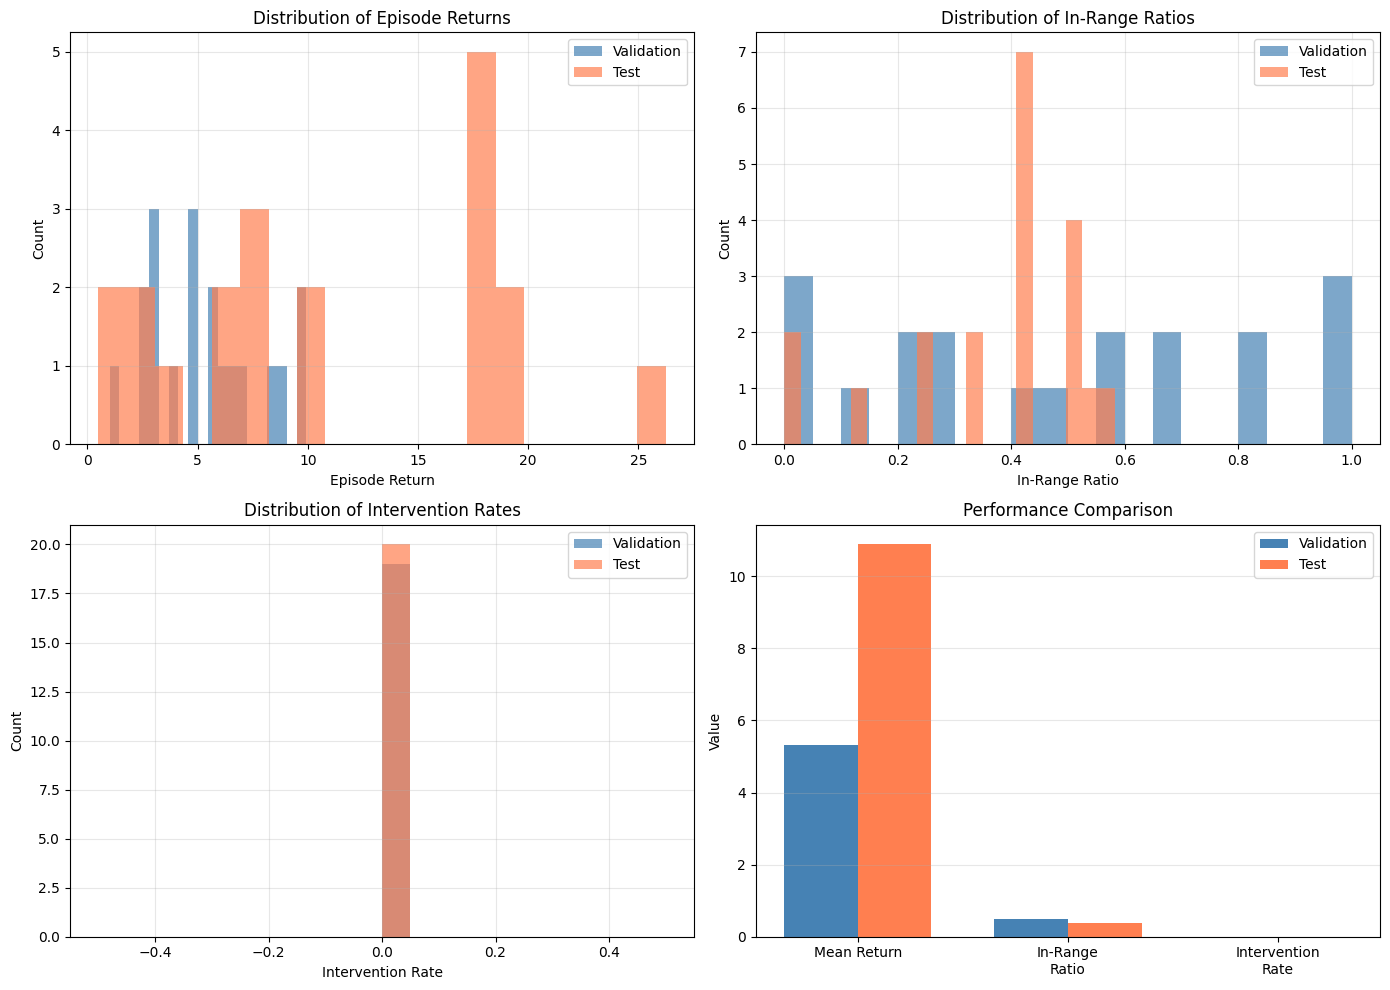

In [34]:
# ====================================================
# 11. Visualization
# ====================================================
print("\n" + "="*50)
print("GENERATING VISUALIZATIONS")
print("="*50)

# Plot returns distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Returns
axes[0, 0].hist(val_results['returns'], bins=20, alpha=0.7, label='Validation', color='steelblue')
axes[0, 0].hist(test_results['returns'], bins=20, alpha=0.7, label='Test', color='coral')
axes[0, 0].set_xlabel("Episode Return")
axes[0, 0].set_ylabel("Count")
axes[0, 0].set_title("Distribution of Episode Returns")
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# In-range ratio
axes[0, 1].hist(val_results['in_range_ratio'], bins=20, alpha=0.7, label='Validation', color='steelblue')
axes[0, 1].hist(test_results['in_range_ratio'], bins=20, alpha=0.7, label='Test', color='coral')
axes[0, 1].set_xlabel("In-Range Ratio")
axes[0, 1].set_ylabel("Count")
axes[0, 1].set_title("Distribution of In-Range Ratios")
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Intervention rate
axes[1, 0].hist(val_results['intervention_rate'], bins=20, alpha=0.7, label='Validation', color='steelblue')
axes[1, 0].hist(test_results['intervention_rate'], bins=20, alpha=0.7, label='Test', color='coral')
axes[1, 0].set_xlabel("Intervention Rate")
axes[1, 0].set_ylabel("Count")
axes[1, 0].set_title("Distribution of Intervention Rates")
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Performance comparison
metrics = ['Mean Return', 'In-Range\nRatio', 'Intervention\nRate']
val_means = [val_results['returns'].mean(), 
             val_results['in_range_ratio'].mean(),
             val_results['intervention_rate'].mean()]
test_means = [test_results['returns'].mean(),
              test_results['in_range_ratio'].mean(),
              test_results['intervention_rate'].mean()]

x = np.arange(len(metrics))
width = 0.35
axes[1, 1].bar(x - width/2, val_means, width, label='Validation', color='steelblue')
axes[1, 1].bar(x + width/2, test_means, width, label='Test', color='coral')
axes[1, 1].set_ylabel('Value')
axes[1, 1].set_title('Performance Comparison')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(metrics)
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()



📈 Visualizing sample trajectories...


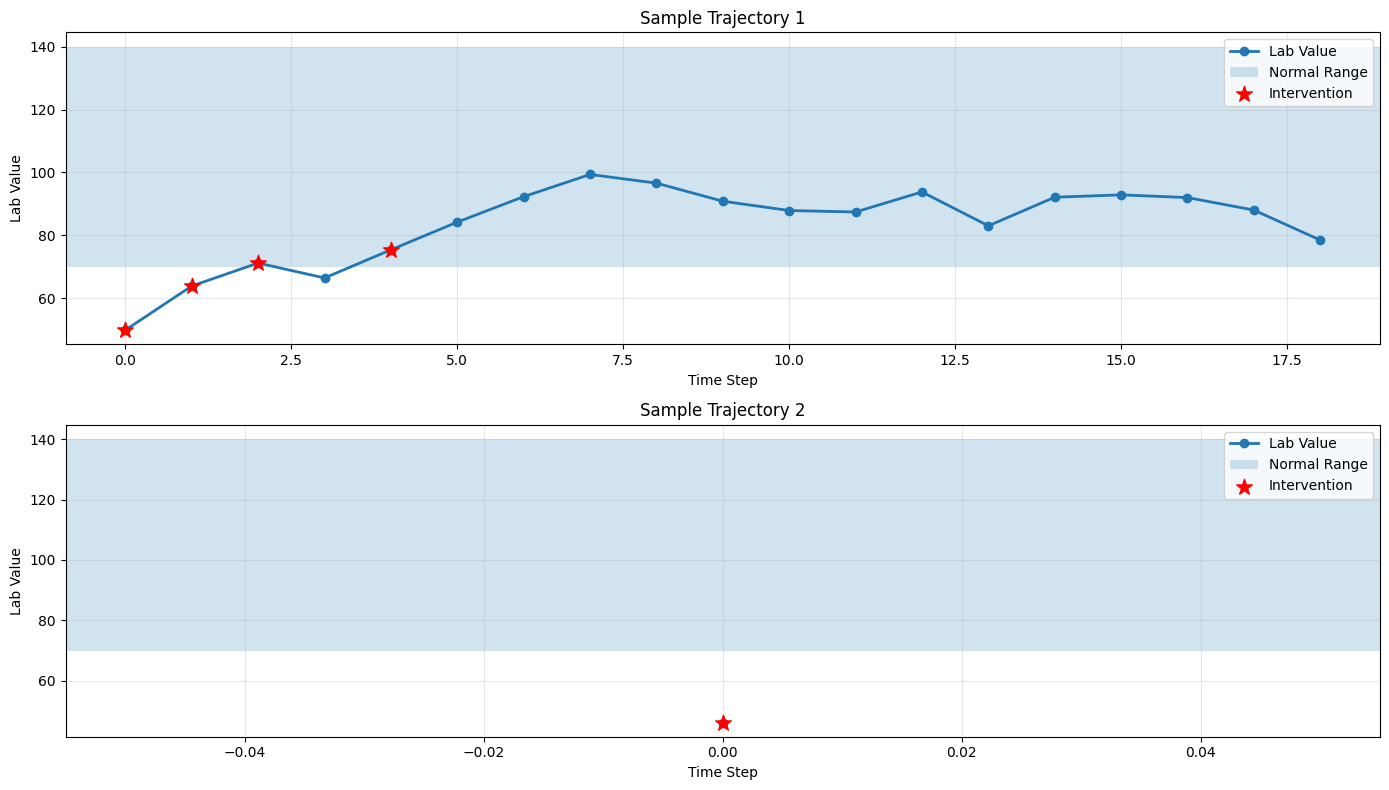

In [35]:
# ====================================================
# 12. Sample Trajectory Visualization
# ====================================================
print("\n📈 Visualizing sample trajectories...")

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Use the *normalized* test_env created in evaluation cell
env_for_plot = test_env  # VecNormalize(DummyVecEnv([HITLClinicalEnv]))

for i in range(2):
    obs = env_for_plot.reset()
    states, actions = [], []
    done = [False]

    while not done[0]:
        # info contains real-valued states; pull them from env step output infos
        action, _ = model.predict(obs, deterministic=True)
        obs, _, done, infos = env_for_plot.step(action)

        info = infos[0]
        states.append(float(info.get("next_state", np.nan)))
        actions.append(int(info.get("action", int(action[0]))))

    axes[i].plot(states, marker='o', linewidth=2, label='Lab Value')
    axes[i].axhspan(NORMAL_RANGE[0], NORMAL_RANGE[1], alpha=0.2, label='Normal Range')

    intervention_steps = [j for j, a in enumerate(actions) if a == 1]
    if intervention_steps:
        axes[i].scatter(intervention_steps,
                        [states[j] for j in intervention_steps],
                        color='red', s=140, marker='*',
                        label='Intervention', zorder=5)

    axes[i].set_xlabel('Time Step')
    axes[i].set_ylabel('Lab Value')
    axes[i].set_title(f'Sample Trajectory {i+1}')
    axes[i].legend(loc='upper right')
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [37]:
# ====================================================
# Save trained model
# ====================================================
from pathlib import Path

Path("models").mkdir(exist_ok=True, parents=True)
model.save("models/ppo_hitl.zip")
print("Saved: models/ppo_hitl.zip")


Saved: models/ppo_hitl.zip


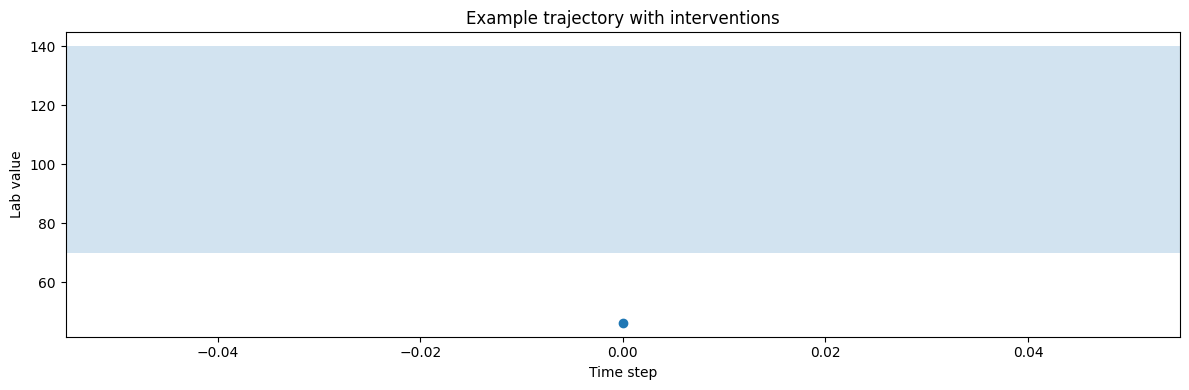

In [38]:
# ====================================================
# Save example trajectories to images/
# ====================================================
import os
os.makedirs("images", exist_ok=True)

plt.figure(figsize=(12, 4))
plt.plot(states, marker="o")
plt.axhspan(NORMAL_RANGE[0], NORMAL_RANGE[1], alpha=0.2)
plt.title("Example trajectory with interventions")
plt.xlabel("Time step")
plt.ylabel("Lab value")
plt.tight_layout()
plt.savefig("images/example_trajectory.png", dpi=200)
plt.show()